# Idea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
from scipy.sparse import csr_matrix

from network_inference import get_cluster_coefs, filter_links

In [3]:
import celloracle as co
%matplotlib inline

In [4]:
#plt.rcParams["figure.figsize"] = [9,6]
#%config InlineBackend.figure_format = 'retina'
#plt.rcParams["savefig.dpi"] = 600

In [5]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

Load data from previous notebook.

In [6]:
#load oracle object
oracle = co.load_hdf5("Pancreas_grn_vel.celloracle.oracle")

## 2. Velocity vs Velocity

In [7]:
#genes that depend only on one transcription factor
one_factor_genes = oracle.coef_matrix_per_cluster['Alpha'].columns[oracle.coef_matrix_per_cluster['Alpha'].astype(bool).sum(axis=0)==1]
df1 = oracle.coef_matrix_per_cluster['Alpha'][one_factor_genes]
df2 = df1[df1.columns[df1.sum()!=1]]

In [8]:
#Dataframe of one-to-one dependencies
TF = [df2[df2[el] != 0].index[0] for el in df2.columns]
weights = [df2[df2[el] != 0][el][0] for el in df2.columns]
target = df2.columns
one_factor_df = pd.DataFrame({'TF':TF,'target':target, 'weight':weights})

In [9]:
one_factor_df

,TF,target,weight
0,Etv5,Snhg6,0.013486
1,Arg1,Fam135a,-0.018046
2,Prdm16,Fam126b,-0.005607
3,Isl1,Mreg,-0.009615
4,Prox1,Cul3,0.097542
...,...,...,...
189,Meis2,Gripap1,-0.056093
190,Zbtb20,Usp9x,0.017099
191,Irx2,Mamld1,0.127740
192,Isl1,Ap1s2,0.042295


In [10]:
from sklearn.linear_model import Ridge

In [11]:
#Ridge Regression from CellOracle
scores = []
gem_alpha = oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('imputed_count')
clf = Ridge(alpha=10)
for i in range(194):
    y = np.array(gem_alpha[one_factor_df['target'][i]]).reshape(-1, 1)
    X = np.array(gem_alpha[one_factor_df['TF'][i]]).reshape(-1, 1)
    clf.fit(X, y)
    scores.append(np.round(clf.score(X,y),3))

In [12]:
#Take the Regression with the highest R² (approx 0.8)
one_factor_df.loc[np.argmax(scores),:]

TF            Irx2
target        Heg1
weight    0.129035
Name: 66, dtype: object

In [13]:
y = np.array(gem_alpha[one_factor_df['target'][66]]).reshape(-1, 1)
X = np.array(gem_alpha[one_factor_df['TF'][66]]).reshape(-1, 1)
clf.fit(X, y)
clf.score(X,y)

0.792292842825898

In [14]:
clf.intercept_

array([-0.02642729])

In [15]:
#Use linear model to predict the velocity
tf_ex = oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('imputed_count')['Irx2']
tf_velo = oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('velocity')['Irx2']
target_velo = oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('velocity')['Heg1']
pred_target_velo = tf_velo * one_factor_df['weight'][66] #no intercept, because we have a change

In [16]:
pred_target_velo.head()

index
AAACCTGAGGCAATTA   -0.014990
AAACCTGTCCCTCTTT   -0.063977
AAACGGGGTCGGGTCT   -0.004994
AAAGATGAGCGCCTCA   -0.071010
AAAGATGAGTACACCT   -0.055805
Name: Irx2, dtype: float64

In [17]:
target_velo.head()

index
AAACCTGAGGCAATTA    0.029339
AAACCTGTCCCTCTTT    0.035833
AAACGGGGTCGGGTCT   -0.002274
AAAGATGAGCGCCTCA    0.028704
AAAGATGAGTACACCT    0.022502
Name: Heg1, dtype: float64

saving figure to file ./figures/scvelo_phase_cell_grn.png


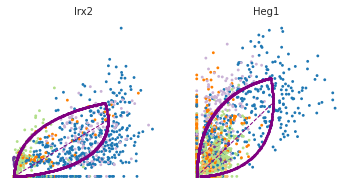

saving figure to file ./figures/scvelo_time_cell_grn.png


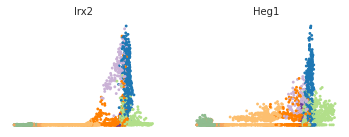

In [34]:
#dependency makes sense
var_names = ['Irx2', 'Heg1']
scv.pl.scatter(oracle.adata, var_names, frameon=False,  figsize=[3,3], save='phase_cell_grn.png')
scv.pl.scatter(oracle.adata, x='latent_time', y=var_names, frameon=False, figsize=[3,2], save='time_cell_grn.png')

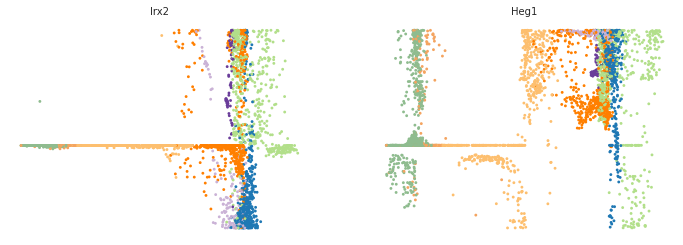

In [20]:
scv.pl.scatter(oracle.adata, x='latent_time', y=var_names, layer ='velocity' ,frameon=False)

In [21]:
oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('velocity').max()

index
Sntg1      0.004630
Snhg6      0.128026
Ncoa2           NaN
Sbspon     0.170461
Ube2w           NaN
             ...   
Tmem27     1.805662
Uty             NaN
Ddx3y           NaN
Eif2s3y    0.088945
Erdr1           NaN
Length: 2000, dtype: float64

In [22]:
oracle.adata[oracle.adata.obs['clusters']=='Alpha'].to_df('imputed_count').max()

index
Sntg1      0.016046
Snhg6      0.231199
Ncoa2      0.182386
Sbspon     0.020956
Ube2w      0.061087
             ...   
Tmem27     2.785533
Uty        0.047803
Ddx3y      0.255338
Eif2s3y    0.259922
Erdr1      0.387181
Length: 2000, dtype: float64

In [23]:
y = np.array(gem_alpha[one_factor_df['target'][66]]).reshape(-1, 1)
X = np.array(gem_alpha[one_factor_df['TF'][66]]).reshape(-1, 1)
clf.fit(X, y)

Ridge(alpha=10)

In [24]:
clf.score(X,y)

0.792292842825898

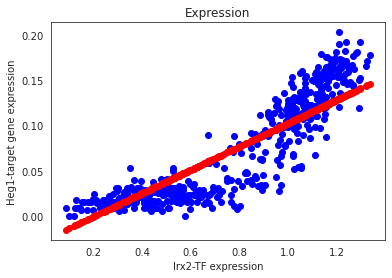

In [28]:
plt.scatter(X,y, c='b')
plt.scatter(X,clf.predict(X), c='r')
plt.xlabel('Irx2-TF expression')
plt.ylabel('Heg1-target gene expression')
plt.title('Expression')
plt.savefig('./figures/tf_vs_target.png')

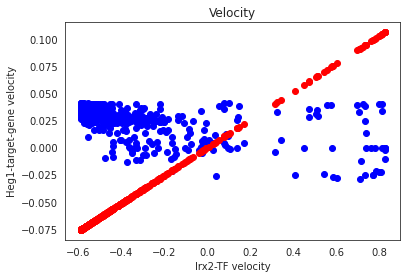

In [29]:
plt.scatter(tf_velo,target_velo, c='b')
plt.scatter(tf_velo,pred_target_velo, c='r')
plt.xlabel('Irx2-TF velocity')
plt.ylabel('Heg1-target-gene velocity')
plt.title('Velocity')
plt.savefig('./figures/tf_vs_target_velo.png')

Text(0.5, 1.0, 'True vs predicted')

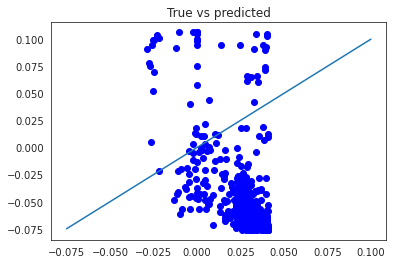

In [62]:
plt.scatter(target_velo,pred_target_velo, c='b')
plt.plot([-0.075,0.1],[-0.075,0.1])
plt.title('True vs predicted')

## 3. Expected value vs Expected value

In [35]:
scv.tl.velocity_confidence(oracle.adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


saving figure to file ./figures/scvelo_velo_confidence.png


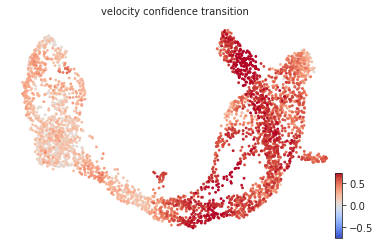

In [37]:
scv.pl.scatter(oracle.adata, c='velocity_confidence_transition', cmap='coolwarm', perc=[5, 95], save='velo_confidence.png')

## 3. Propagating the signal of Ezh2 in Ductal Cells and Atf3 in Epsilon Cells

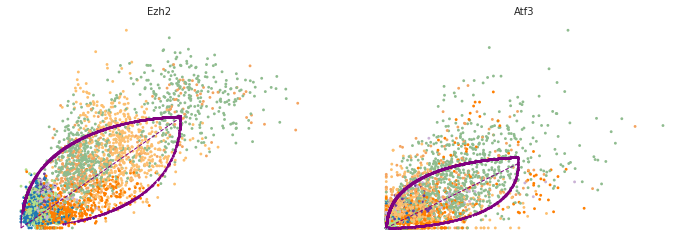

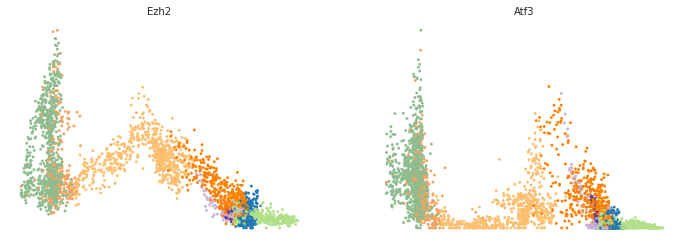

In [29]:
scv.pl.scatter(oracle.adata, ['Ezh2', 'Atf3'], frameon=False)
scv.pl.scatter(oracle.adata, x='latent_time', y=['Ezh2', 'Atf3'], frameon=False)

In [30]:
cluster_info = oracle.adata.obs['clusters']

In [31]:
gem = oracle.adata.to_df('imputed_count')
simulation_input = gem.copy()

mask = cluster_info =='Ductal'
gene_velo = oracle.adata.to_df('velocity')[cluster_info == 'Ductal']['Ezh2']
simulation_input.loc[mask, 'Ezh2'] = gem[cluster_info == 'Ductal']['Ezh2'] + gene_velo

n_propagation = 2
simulated = []

In [32]:
for cluster in ['Ductal']:
    
    simulation_input_ = simulation_input[cluster_info == cluster] #future value of transcription factors
    gem_ = gem[cluster_info == cluster].copy() #expression matrix
    
    coef_matrix = oracle.coef_matrix_per_cluster[cluster] #coefficient matrix
    
    delta_input = simulation_input_ - gem_ #difference in TF expression (from t1 to t0), the other genes are zero

    delta_simulated = delta_input.copy() 
    
    for i in range(n_propagation):
        delta_simulated = delta_simulated.dot(coef_matrix) #propagate the difference in expression of TFs using the coefficients
        delta_simulated[delta_input != 0] = delta_input #do not predict the transcription of out input gene

        # gene expression cannot be negative. adjust delta values to make sure that gene expression are not negative values.
        gem_tmp = gem_ + delta_simulated #add the change in expression of other genes, to obtain their future value
        gem_tmp[gem_tmp<0] = 0 #do not allow negative counts
        delta_simulated = gem_tmp - gem_ #new difference in expression 

    gem_simulated = gem_ + delta_simulated #add the difference in expression to obtain the future value
    
    simulated_in_the_cluster = gem_simulated 
    
    simulated.append(simulated_in_the_cluster)
        
gem_simulated = pd.concat(simulated, axis=0)

In [33]:
grn_df = gem.copy() * 0
grn_df.loc[mask,:] = gem_simulated - gem[cluster_info == 'Ductal']
oracle.adata.layers['_grn_'] = grn_df

In [34]:
scv.tl.velocity_graph(oracle.adata, vkey='_grn_')

computing velocity graph
    finished (0:00:02) --> added 
    '_grn__graph', sparse matrix with cosine correlations (adata.uns)


In [35]:
scv.tl.velocity_embedding(oracle.adata, vkey = '_grn_')

computing velocity embedding
    finished (0:00:00) --> added
    '_grn__umap', embedded velocity vectors (adata.obsm)


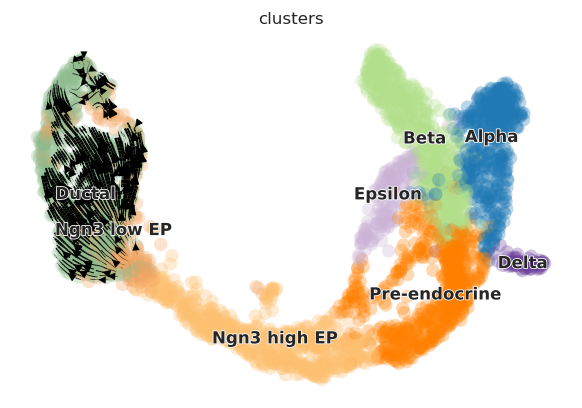

In [36]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='_grn_', dpi=120)

In [38]:
oracle.coef_matrix_per_cluster['Alpha']

,Sntg1,Snhg6,Ncoa2,Sbspon,Ube2w,Mcm3,Fam135a,Adgrb3,Tmem131,Tbc1d8,...,Sh3kbp1,Map3k15,Rai2,Rbbp7,Ap1s2,Tmem27,Uty,Ddx3y,Eif2s3y,Erdr1
Sntg1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snhg6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ncoa2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sbspon,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ube2w,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmem27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Uty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Ddx3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eif2s3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
np.array(df1[df1.columns[df1.sum()==1]].columns)

array(['Sntg1', 'Ncoa2', 'Sbspon', ..., 'Sh3kbp1', 'Uty', 'Erdr1'],
      dtype=object)

In [44]:
adj_mtx = oracle.coef_matrix_per_cluster['Alpha'].copy().drop(np.array(df1[df1.columns[df1.sum()==1]].columns), axis=1)

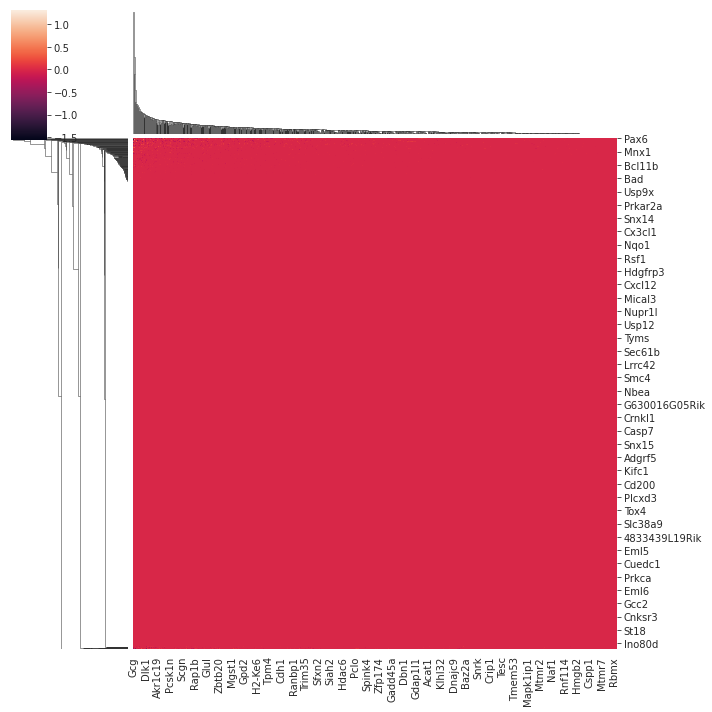

In [48]:
sns.clustermap(adj_mtx)